1. Загружаю сабсет из 100к
2. Удаля NA titles
3. удаляю дубликаты titles
4. токенизация
5. лемматизация
6. Снижаем размерность UMAP
7. HDBSCAN
8. LDA

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

from tqdm import tqdm
import pyLDAvis

import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import LatentDirichletAllocation as LDA

import nltk
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer 
from stop_words import get_stop_words

stop_words = get_stop_words('en')

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\OgO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\OgO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [16]:
def predproccess(s):
    s = s.lower()
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(s)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]
    return tokens

In [4]:
df = pd.read_csv('made/eda/first_batch_100_000.csv', sep='|')
df.dropna(subset='title', inplace=True)

In [5]:
df.drop_duplicates(subset='title', inplace=True)
df.reset_index(inplace=True)

In [6]:
titles = df.title

In [7]:
titles.shape

(96882,)

In [50]:
vectorizer = CountVectorizer(analyzer=predproccess)

In [51]:
embeddings = vectorizer.fit_transform(titles)

# UMAP

In [10]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

# HDBSCAN

In [11]:
cluster = hdbscan.HDBSCAN(min_cluster_size=50,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [28]:
labels = pd.Series(cluster.labels_)

-1 - не удалось отнести к классу (выброс)

In [29]:
labels.value_counts()

-1      54425
 63      1439
 55      1183
 213     1078
 90      1014
        ...  
 80        52
 124       52
 181       52
 140       51
 210       50
Length: 218, dtype: int64

In [42]:
indexes_for_class = labels[labels == 63].values.nonzero()[0]

In [43]:
titles[indexes_for_class].values

array(['3GIO.',
       'The relationship between canopy parameters and spectrum of winter wheat under different irrigations in Hebei Province.',
       'A solution to the problem of touching and broken characters.',
       ..., 'LinguaBytes', 'Lilliput', 'L'], dtype=object)

Работает неприятно

# LRA

In [82]:
models = [0, 0]
scores = [float('-inf'), float('-inf')]
for n_topics in tqdm(range(2, 101)):
    lda_model = LDA(n_components=n_topics, random_state=42)
    lda_model.fit(embeddings)
    
    models.append(lda_model)
    scores.append(lda_model.score(embeddings))

100%|███████████████████████████████████████████████████████████████████████████████| 99/99 [2:49:16<00:00, 102.59s/it]


In [83]:
best_n_topics = scores.index(max(scores))
best_model = models[best_n_topics]
print(f'Best n topics: {best_n_topics} with score {scores[best_n_topics]}')

Best n topics: 2 with score -3440408.805233806


In [84]:
data = pyLDAvis.sklearn.prepare(best_model, embeddings, vectorizer)
pyLDAvis.display(data)

Слишком абстрактные классы

In [89]:
step_scores = np.array(scores.copy())

<AxesSubplot:>

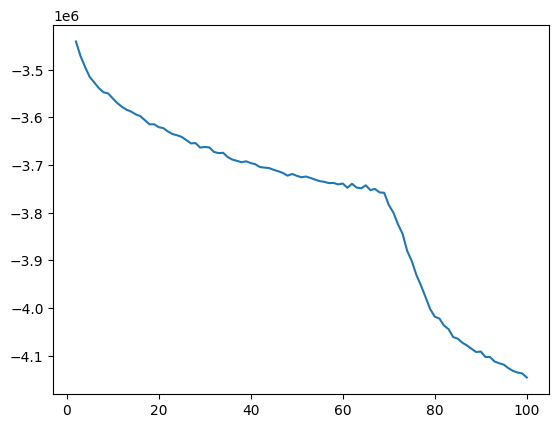

In [88]:
sns.lineplot(x=np.arange(2, 101), y=step_scores[2:])

In [91]:
np.argsort(step_scores)[::-1]

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  19,  18,  20,  21,  22,  23,  24,  25,  26,  28,
        27,  30,  31,  29,  32,  34,  33,  35,  36,  37,  39,  38,  40,
        41,  42,  43,  44,  45,  46,  47,  49,  48,  50,  52,  51,  53,
        54,  55,  56,  58,  57,  60,  62,  59,  65,  63,  61,  64,  67,
        66,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  90,  89,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100,   1,   0], dtype=int64)

 Увеличение числа классов увеличивает энтропию,нарушает эту закономерность 28 признаков (0, 1 признак - заглушки)

In [92]:
data = pyLDAvis.sklearn.prepare(models[28], embeddings, vectorizer)
pyLDAvis.display(data)

Чет не оч

Рассмотрим первые 10 значений и визуально выберем лучшую при максимизации классов

In [96]:
print('12 классов')
data = pyLDAvis.sklearn.prepare(models[12], embeddings, vectorizer)
pyLDAvis.display(data)

12 классов


In [97]:
print('11 классов')
data = pyLDAvis.sklearn.prepare(models[11], embeddings, vectorizer)
pyLDAvis.display(data)

11 классов


In [98]:
print('10 классов')
data = pyLDAvis.sklearn.prepare(models[10], embeddings, vectorizer)
pyLDAvis.display(data)

10 классов


In [99]:
print('9 классов')
data = pyLDAvis.sklearn.prepare(models[9], embeddings, vectorizer)
pyLDAvis.display(data)

9 классов


Остановимся на десяти классах. Все классы связаны с IT, этим объясняется падение скора при росте числа топиков

Несколько классов:
* 3 - методы оптимизации
* 8 - software
* 10 - ML
* 4 - Применение ML

In [103]:
model_10 = models[10]

In [111]:
pickle.dump(model_10, open('model_10_topics','wb'))